# Unveiling Bias in Gender Violence Perception on Italian Social Media

## Importing Libraries

In [226]:
%pip install clean-text

In [227]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import spacy
from cleantext import clean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


In [228]:
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 18.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Reading and Cleaning Data

### Read Df

This data frame comes from extensive and hard scraping on Nitter, one of the last available resources to scrape Twitter without rate limits and high expenses. However, because of the instability of the various instances, we are not sure the results will be easily replicated if trying to run again the twitter.ipynb script.

In [318]:
# read the data
df = pd.read_csv('twitter_data_ext.csv')

In [288]:
# drop the first column
#df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,Apr 19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,Apr 19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,Apr 19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,Apr 19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,Apr 19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


In [289]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62624 entries, 0 to 62623
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user      62623 non-null  object
 1   username  62624 non-null  object
 2   date      62624 non-null  object
 3   text      62622 non-null  object
 4   comments  62624 non-null  int64 
 5   retweets  62624 non-null  object
 6   quotes    62624 non-null  int64 
 7   likes     62624 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


In [290]:
# check date data type
df['date'].unique()

array(['Apr 19', 'Apr 18', 'Apr 15', 'Mar 8', 'Apr 17', '6 Dec 2023',
       '18 Nov 2023', 'Apr 16', 'Apr 13', 'Apr 14', 'Apr 12', 'Apr 11',
       'Apr 10', 'Apr 9', 'Apr 8', 'Apr 7', 'Apr 6', 'Apr 5', 'Apr 4',
       'Apr 3', 'Apr 2', 'Apr 1', 'Mar 31', 'Mar 30', 'Mar 29', 'Mar 28',
       'Mar 27', 'Mar 26', 'Mar 25', 'Mar 24', 'Mar 23', 'Mar 22',
       'Mar 21', 'Mar 20', 'Mar 19', 'Mar 18', 'Mar 17', 'Mar 16',
       'Mar 15', 'Mar 14', 'Mar 13', 'Mar 12', 'Mar 11', 'Mar 10',
       'Mar 9', 'Mar 7', 'Mar 6', 'Mar 5', 'Mar 4', 'Mar 3', 'Mar 2',
       'Mar 1', 'Feb 29', 'Feb 28', 'Feb 27', 'Feb 26', 'Feb 25',
       'Feb 24', 'Feb 23', 'Feb 22', 'Feb 21', 'Feb 20', 'Feb 19',
       'Feb 18', 'Feb 17', 'Feb 16', 'Feb 15', 'Feb 14', 'Feb 13',
       'Feb 12', 'Feb 11', 'Feb 10', 'Feb 9', 'Feb 8', 'Feb 7', 'Feb 6',
       'Feb 5', 'Feb 4', 'Feb 3', 'Feb 2', 'Feb 1', 'Jan 31', 'Jan 30',
       'Jan 29', 'Jan 28', 'Jan 27', 'Jan 26', 'Jan 25', 'Jan 24',
       'Jan 23', 'Jan 22', 'Ja

The dates of 2024 have been saved with just day and month, therefore we need to add the year

In [291]:
len('9 Dec 2023')

10

In [319]:
# add the year to all the dates of 2024
df['date'] = df['date'].apply(lambda x: x + ' 2024' if len(x) < 10 else x)

In [320]:
# convert the date to datetime
df['date'] = pd.to_datetime(df['date'], format = 'mixed')

In [321]:
# clean the text column
df['text'] = df['text'].apply(lambda x: str(x).replace('\n', ' '))

In [322]:
# first five rows
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,2024-04-19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,2024-04-19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,2024-04-19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,2024-04-19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,2024-04-19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


This is the cleaned final data frame!

## Exploratory Data Analysis

### Polarization event

We chose as a polarization event the "Cecchettin case", that greatly moved public opinion regarding the hot topic of violence on women in italy.

In [323]:
# create a variable for the polarizing event
pol_event = dt.datetime(2023, 11, 11)

### Simple Tweet Count

In [324]:
# group the data by date
count_by_date = df.groupby('date').count()
count_by_date.head()

,user,username,text,comments,retweets,quotes,likes
date,,,,,,,
2022-02-16,15,15,15,15,15,15,15
2022-02-17,24,24,24,24,24,24,24
2022-02-18,19,19,19,19,19,19,19
2022-02-19,11,11,11,11,11,11,11
2022-02-20,4,4,4,4,4,4,4


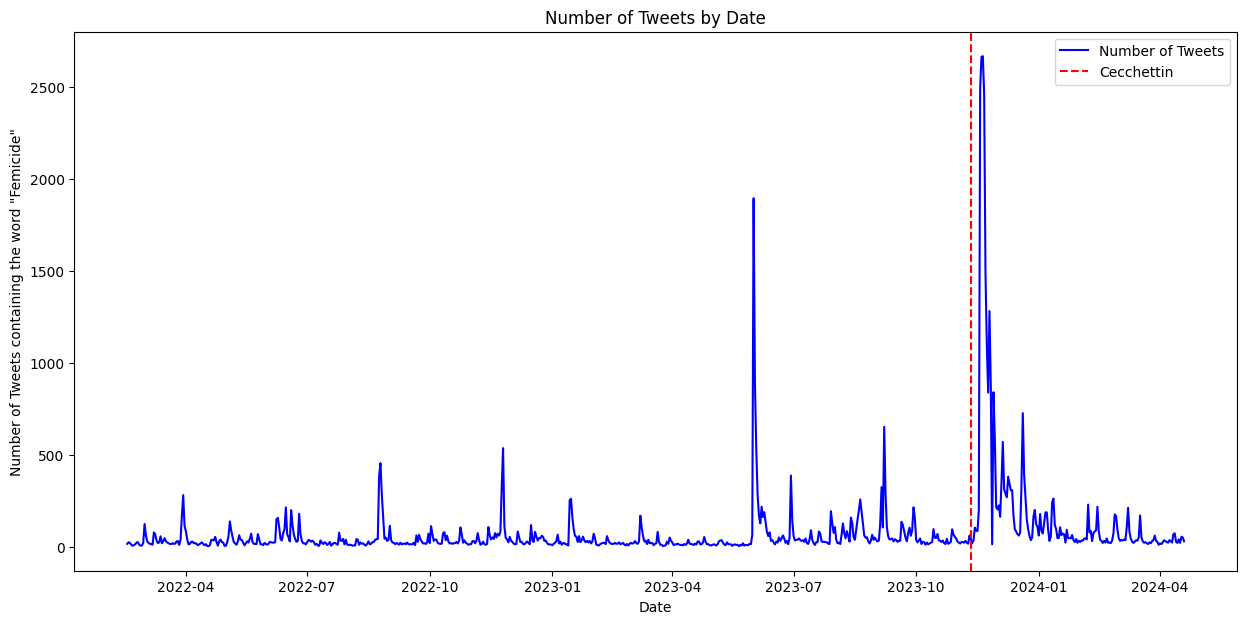

In [325]:
# plot the number of tweets by date
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(count_by_date.index, count_by_date['text'], label='Number of Tweets', color='blue')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets containing the word "Femicide"')
ax.legend()

plt.show()

### Number of Different Users

In [326]:
# count the number of different users
n_different_users = df['user'].nunique()
print(f'There are {n_different_users} different users in the dataset (that contains {len(df)} tweets)')

There are 23742 different users in the dataset (that contains 62624 tweets)


In [327]:
# list of all different users
different_users = df['user'].unique()
different_users

array(['Sciking', '💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫',
       'pubblicanow.it', ...,
       '.•.°• 🦦|| young royals & liceali gay era °.•', 'Lucia Guarano',
       'Laura Garavini'], dtype=object)

In [328]:
users_df = df.groupby('user').agg(list).reset_index()
users_df['username'] = users_df['username'].apply(lambda x: x[0])
users_df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,raffaele52,@raffaele521,[2023-11-21 00:00:00],[La sua conoscenza del femminicidio è straordi...,[0],[0],[0],[0]
1,Shana Loricco,@shanaloricco201,[2023-12-05 00:00:00],"[Parole forti, chiare. Giuste. #LorenzoGasparr...",[0],[0],[0],[0]
2,"""Lehodettocresci"" E io sono cresciuta🌈🌻",@nagioia08,"[2023-10-04 00:00:00, 2023-06-01 00:00:00, 202...",[D'altronde Pi3rsilvio ha cacciato la d'urso p...,"[0, 0, 2, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[ 8, 0, 0, 3]"
3,"""seneca&pericle""",@senecaepericle,[2023-01-24 00:00:00],[Non parliamo poi del femminicidio...],[0],[0],[0],[0]
4,# claudia ✧ 🔭,@308bangtan,[2023-08-01 00:00:00],"[in realtà penalmente parlando non è uguale, u...",[0],[0],[0],[0]


In [329]:
users_df['n_tweets'] = users_df['text'].apply(lambda x: len(x))

### Number of Tweets per User

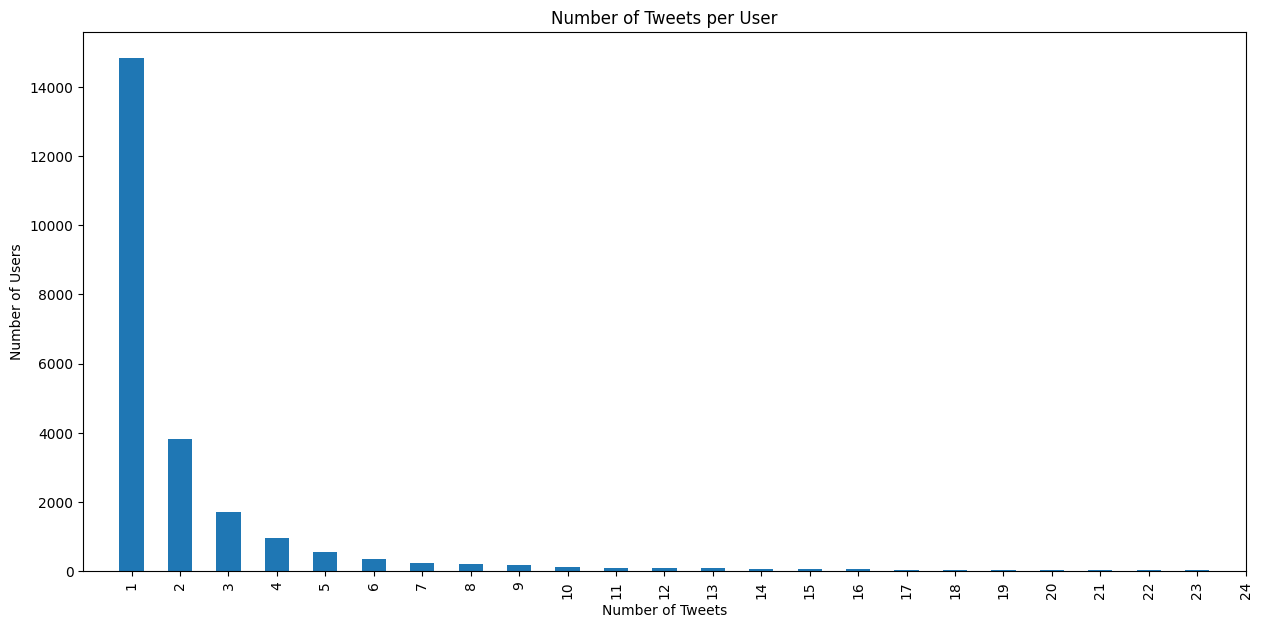

In [330]:
fig, ax = plt.subplots(figsize=(15, 7))
users_df['n_tweets'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of Tweets per User')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Users')
ax.set_xlim(-1, 23)

plt.show()

## Data Processing

### Split Dates

In [331]:
pol_event_date = dt.datetime(2023, 11, 11)
df['after'] = 0
df.loc[df['date'] > pol_event_date, 'after'] = 1

### Create Hashtag Column

In [332]:
# function to get hashtags
def get_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    if hashtags != []:
        return re.findall(r'#\w+', text)
    else:
        return np.nan

In [333]:
df['hashtags'] = df['text'].apply(get_hashtags)

In [334]:
df.loc[df['hashtags'].notna(), 'hashtags'].reset_index(drop=True)

0                            [#femminicidio, #femminicidi]
1                                               [#Raiplay]
2                                          [#Femminicidio]
3                    [#Attualità, #Italia, #UltimeNotizie]
4                                   [#Sardegna, #violenza]
                               ...                        
22072    [#humanrights, #Imrali, #Turkey, #FreeOcalanNo...
22073            [#humanrights, #Turkey, #Kurds, #podcast]
22074                                     [#FreeOcalanNow]
22075                        [#eutanasialegale, #medioevo]
22076         [#uominimaltrattanti, #femminicidio, #donne]
Name: hashtags, Length: 22077, dtype: object

### Clean Tweets

In [380]:
def remover(text, chars = ['@', '#', 'http']):

    starting_chars = '|'.join(chars)
    for word in text.split():
        if re.match(f'{starting_chars}[A-za-z]+', word):
            text = text.replace(word, '')

    return text
def remove_apostrophe(text):
    return text.replace("'", " ")
def remove_words_under(text, n=3):
    return ' '.join([word for word in text.split() if len(word) > n])
def duster(text):
    return remove_words_under(remove_apostrophe(remover(text)))
df['clean_text'] = df['text'].apply(lambda x: duster(x).lower())
df['clean_text'] = df['clean_text'].apply(lambda x: clean(x, no_urls=True, no_emails=True, no_phone_numbers=True, no_numbers=True, no_digits=True, no_currency_symbols=True, no_punct=True, no_emoji=True, replace_with_url='', replace_with_email='', replace_with_phone_number='', replace_with_number='', replace_with_digit='', replace_with_currency_symbol='', replace_with_punct=''))


In [363]:
display(df.head())

,user,username,date,text,comments,retweets,quotes,likes,after,hashtags,clean_text
0,Sciking,@ScikingFS,2024-04-19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0,1,NaN,se solo le donne possono parlare di aborto sol...
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,2024-04-19,#femminicidio #femminicidi,0,0,0,0,1,"[#femminicidio, #femminicidi]",
2,pubblicanow.it,@pubblicanow,2024-04-19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0,1,NaN,paesi baschi aiuto annuale per gli orfani di f...
3,Italy in Austria,@ItalyinAustria,2024-04-19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0,1,NaN,ambasciata italia vienna aderisce alla campagn...
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,2024-04-19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1,1,NaN,bhe speriamo che non sia per qualche femminici...


In [381]:
nlp = spacy.load('it_core_news_sm')

In [382]:
texts_before = df.loc[df['after'] == 0, 'clean_text'].values
texts_after = df.loc[df['after'] == 1, 'clean_text'].values
documents_before = list(nlp.pipe(texts_before))
documents_after = list(nlp.pipe(texts_after))


In [383]:
corpus_before = [[word.text for word in doc if not word.is_stop] for doc in documents_before]
corpus_after = [[word.text for word in doc if not word.is_stop] for doc in documents_after]

In [384]:
from gensim.models import word2vec
import os

w2v_before = word2vec.Word2Vec(corpus_before, vector_size=100, window=5, min_count=1, workers=os.cpu_count())
w2v_after = word2vec.Word2Vec(corpus_after, vector_size=100, window=5, min_count=1, workers=os.cpu_count())

In [404]:
w2v_before.wv.most_similar('giustizia')

[('incontro', 0.9994591474533081),
 ('buona', 0.9994065165519714),
 ('frutto', 0.9992736577987671),
 ('evento', 0.9992488622665405),
 ('discussione', 0.9992009997367859),
 ('tempi', 0.9991640448570251),
 ('fratelli', 0.9991249442100525),
 ('twitter', 0.9991002082824707),
 ('riflessione', 0.9990702867507935),
 ('forte', 0.9990652203559875)]

In [405]:
w2v_after.wv.most_similar('giustizia')

[('triste', 0.9992445111274719),
 ('spero', 0.9990488886833191),
 ('dispiace', 0.9989916682243347),
 ('viva', 0.9986889958381653),
 ('settimane', 0.9986626505851746),
 ('sorriso', 0.9986414909362793),
 ('deciso', 0.998588502407074),
 ('social', 0.9985312223434448),
 ('chiedo', 0.9985125660896301),
 ('sentito', 0.9984902143478394)]

In [ ]:
def similarity_before_after(words, model_before, model_after):
    if type(words) == str:
        try:
            vec_before = model_before.wv[words]
            vec_after = model_after.wv[words]
            similarity = cosine_similarity([vec_before], [vec_after])
            return {words: similarity[0][0]}
        except KeyError:
            return {words: 'word not in vocabulary'}
    else:
        similarities = {}
        for word in words:
            try:
                vec_before = model_before.wv[word]
                vec_after = model_after.wv[word]
                similarity = cosine_similarity([vec_before], [vec_after])
                similarities[word] = similarity[0][0]
            except KeyError:
                similarities[word] = 'word not in vocabulary'
        return similarities

In [ ]:
word = 'femminicidio'
similarity = similarity_before_after(word, w2v_before, w2v_after)
print(f'the similarity between the word {word} before and after the event is {similarity[word]}')

In [ ]:
polarizing_words = ['destra', 'sinistra', 'donna', 'aborto', 'giustizia', 'femminicidio', 'omicidio', 'violenza']
similarities = similarity_before_after(polarizing_words, w2v_before, w2v_after)
for word in similarities:
    print(f'the similarity between the word {word} before and after the event is {similarities[word]}')

In [ ]:
vocab_before = list(w2v_before.wv.key_to_index)
X_before = w2v_before.wv[vocab_before]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_before)

In [ ]:
vocab_after = list(w2v_after.wv.key_to_index)
X_after = w2v_after.wv[vocab_after]
tsne = TSNE(n_components=2)
X_tsne_after = tsne.fit_transform(X_after)

In [ ]:
df_before = pd.DataFrame(X_tsne, index=vocab_before, columns=['x', 'y'])
df_after = pd.DataFrame(X_tsne_after, index = vocab_after, columns = ['x', 'y'])

In [ ]:
df_before = df_before.loc[polarizing_words]
df_after = df_after.loc[polarizing_words]

In [ ]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_before['x'], df_before['y'], color = 'blue', label = 'embeddings before')
ax.scatter(df_after['x'], df_after['y'], color = 'orange', label = 'embeddings after')
ax.legend()

for word, pos in df_before.iterrows():
    ax.annotate(word, pos)
for word, pos in df_after.iterrows():
    ax.annotate(word, pos)
plt.title('Embeddings 2D Visualization')
plt.show()

# Word Comparison
After fitting the embedding models, we have defined different sets of words that are related to specific concepts we consider to be significant. Our aim is to analyze whether the relative meaning of these words has changed over time.

The terms we explore are grouped under the following groups:


*   Victim related words
*   Murderer related words


*   Words that explore the emotional sphere, both in its negative and positive aspects

*   Words that describe bodily parts and other macabre details

*   Modal words that express the concept of "need" or "change"
*   Words expressing anger due to discrimination and the concept of 'patriarchy'

WARNING: words in point 4 contain disturbing and sensitive content














In [409]:
from copy import deepcopy

#define a function that converts the word2vec models into numpy arrays
def w2v_to_numpy (model):
  model.wv.fill_norms()
  embeddings = deepcopy (model.wv.get_normed_vectors())
  idx = {w:i for i, w in enumerate (model.wv.index_to_key)}
  iidx = {i:w for i, w in enumerate (model.wv.index_to_key)}

  return embeddings, (idx, iidx)

#define a function that returns the nearest neighbors of a query
def near_neighbors (embs, query, word2rownum, rownum2word, k=5):
  sims = np.dot (embs, embs[word2rownum[query]])
  indices = np.argsort (-sims)

  return [(rownum2word[index], sims[index]) for index in indices[1:k+1]]

In [410]:
#define functions to make meaningful comparisons of words across models
def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def intersect_vocab (idx1, idx2):
  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)}, {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_matrices (mat1, mat2, idx1, idx2):
  common_vocab, (common_idx, common_iidx) = intersect_vocab (idx1, idx2)
  row_nums1 = [idx1[v] for v in common_vocab]
  row_nums2 = [idx2[v] for v in common_vocab]

  remapped_mat1 = mat1[row_nums1, :]
  remapped_mat2 = mat2[row_nums2, :]
  omega = procrustes (remapped_mat1, remapped_mat2)

  rotated_mat2 = np.dot (remapped_mat2, omega)

  return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

In [411]:
before_embs, (before_idx, before_iidx) = w2v_to_numpy(w2v_before)
after_embs, (after_idx, after_iidx) = w2v_to_numpy(w2v_after)
before_aligned_embs, after_aligned_embs, (common_idx, common_iidx) = align_matrices (before_embs, after_embs, before_idx, after_idx)

In [412]:
#define the sets of words
victim_words = ['vittima', 'assassinata','innocente']
murderer_words = ['omicida', 'assassino', 'mostro', 'colpevole','delinquente', 'criminale']
emotional_neg_words = ['gelosia', 'tradimento', 'rifiuto','vendetta']
emotional_pos_words = ['passione','felici', 'amore', 'rispetto']
crude_words = ['sangue', 'cadavere', 'strangolata', 'violenza', 'tortura']
modal_words = ['dovere', 'necessario', 'bisogno', 'occorre', 'urgente', 'essenziale', 'fondamentale']
patriarchy_words = ['patriarcato', 'ingiustizia', 'oppressione', 'discriminazione','sessismo', 'retrogrado']


## Across models comparison (how words evolved over time)

In [413]:
#victim related words comparison across models
victim_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in victim_words]
for w,score in sorted (victim_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

innocente 0.9977517
assassinata 0.9898674
vittima 0.9398283


In [414]:
#murderer related words comparison across models
murderer_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in murderer_words]
for w,score in sorted (murderer_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

colpevole 0.9953542
omicida 0.99289125
mostro 0.99199396
criminale 0.9833318
assassino 0.9797154
delinquente 0.9734261


In [415]:
#negative emotional words comparison across models
emotional_neg_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_neg_words]
for w,score in sorted (emotional_neg_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

rifiuto 0.9964168
vendetta 0.996413
tradimento 0.98704934
gelosia 0.9829128


In [416]:
#positive emotional words comparison across models
emotional_pos_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_pos_words]
for w,score in sorted (emotional_pos_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

felici 0.9966524
rispetto 0.9849361
passione 0.97055155
amore 0.9623635


In [393]:
#crude words comparison across models
crude_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in crude_words]
for w,score in sorted (crude_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

sangue 0.99634016
cadavere 0.989227
tortura 0.9601697
strangolata 0.93888324
violenza 0.9170184


In [394]:
#modal words comparison across models
modal_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in modal_words]
for w,score in sorted (modal_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

bisogno 0.998064
urgente 0.9980351
dovere 0.9970209
necessario 0.9963515
fondamentale 0.9960625
occorre 0.99602866
essenziale 0.9762582


In [395]:
#patriarchy words comparison across models
patriarchy_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in patriarchy_words]
for w,score in sorted (patriarchy_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

discriminazione 0.9872285
sessismo 0.98521173
oppressione 0.97505295
patriarcato 0.9629857
ingiustizia 0.9568256
retrogrado 0.8456443


We now compare the most and least similar words between the models, across the entire vocabulary

In [396]:
sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in common_idx.keys()]

print('Most similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=True)[0:10]:
  print (w, sim)
print()
print()
print('Least similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=False)[0:10]:
  print (w, sim)

Most similar words
trovare 0.9996078
farsi 0.99944186
euro 0.9994198
sicuramente 0.9994029
informazione 0.9992257
gioco 0.99920475
solita 0.9991866
argomenti 0.99917936
gender 0.9991672
prendere 0.99907386


Least similar words
esplicitamente -0.68418914
assegnazione -0.67741734
timido -0.5897331
rivoltante -0.5769793
edi -0.5568508
distorcendo -0.53548926
uninvenzione -0.52316505
street -0.5073759
pensasse -0.4626402
parigi -0.45625666


## Within model comparison

In [397]:
#nearest neighbors for victim related words
for word in victim_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "vittima" in the before corpus
('unaltra', 0.9927164)
('bellariva', 0.9923849)
('apricena', 0.99228704)
('mandatoriccio', 0.9916403)
('castelfiorentino', 0.99162936)

Near neighbors for "vittima" in the after corpus
('ennesima', 0.98705876)
('povera', 0.9732596)
('altra', 0.9725958)
('litigano', 0.9709418)
('liliana', 0.9703567)


Near neighbors for "assassinata" in the before corpus
('corpo', 0.9988596)
('scomparsa', 0.99854743)
('lavorava', 0.9984508)
('cadavere', 0.998404)
('aggredita', 0.99810946)

Near neighbors for "assassinata" in the after corpus
('voleva', 0.9985063)
('ricercato', 0.99806374)
('bovolenta', 0.997776)
('bambino', 0.9975957)
('possessivo', 0.99755275)


Near neighbors for "innocente" in the before corpus
('viva', 0.9990983)
('bambina', 0.9990897)
('giuseppe', 0.9990426)
('dettagli', 0.9990329)
('teresa', 0.9989982)

Near neighbors for "innocente" in the after corpus
('cerca', 0.9986821)
('carabinieri', 0.99863535)
('nipote', 0.9986187)
('omicid

In [398]:
#nearest neighbors for murderer related words
for word in murderer_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "omicida" in the before corpus
('mattina', 0.9996023)
('ragazzo', 0.99958813)
('gabriela', 0.9994875)
('finita', 0.9994733)
('procura', 0.99946874)

Near neighbors for "omicida" in the after corpus
('indagini', 0.9989418)
('nipote', 0.9989101)
('notte', 0.99882627)
('procuratore', 0.9988155)
('crudele', 0.99881124)


Near neighbors for "assassino" in the before corpus
('marocchino', 0.9980561)
('mamma', 0.9977947)
('notte', 0.9976469)
('lite', 0.9976469)
('nappini', 0.9974209)

Near neighbors for "assassino" in the after corpus
('bambino', 0.99637616)
('bovolenta', 0.99571705)
('assassinata', 0.9955443)
('riese', 0.9948918)
('auriane', 0.9947639)


Near neighbors for "mostro" in the before corpus
('autore', 0.99953324)
('resta', 0.9995176)
('chiede', 0.99950343)
('papa', 0.99945307)
('bagno', 0.9994433)

Near neighbors for "mostro" in the after corpus
('vomitare', 0.9971895)
('colpevole', 0.9969144)
('agenti', 0.9966272)
('debba', 0.9965569)
('fatta', 0.9965012)


Ne

In [399]:
#nearest neighbors for positive emotional words
for word in emotional_pos_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "passione" in the before corpus
('pubblico', 0.99908686)
('scrivere', 0.998984)
('penso', 0.9989687)
('giornalista', 0.998958)
('dispiace', 0.9989046)

Near neighbors for "passione" in the after corpus
('chiamare', 0.9953128)
('chiamato', 0.99434346)
('sente', 0.9943111)
('rientra', 0.99375534)
('chiamarlo', 0.9936414)


Near neighbors for "felici" in the before corpus
('culo', 0.9987873)
('accettare', 0.99875784)
('genitori', 0.9987539)
('farlo', 0.9987489)
('farsi', 0.9987315)

Near neighbors for "felici" in the after corpus
('limiti', 0.99823487)
('cervello', 0.9982122)
('fisico', 0.99818426)
('effetti', 0.99803424)
('potresti', 0.9980131)


Near neighbors for "amore" in the before corpus
('stop', 0.9987523)
('solidarieta', 0.998505)
('mafia', 0.99836415)
('odio', 0.9983313)
('mura', 0.99815136)

Near neighbors for "amore" in the after corpus
('lascia', 0.9980884)
('accusa', 0.9979909)
('indagini', 0.99766946)
('omicida', 0.99757445)
('nipote', 0.9975651)


Near n

In [400]:
#nearest neighbors for negative emotional words
for word in emotional_neg_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "gelosia" in the before corpus
('scoperto', 0.99896634)
('tragedia', 0.9988378)
('chiamare', 0.9988261)
('allarme', 0.9987146)
('pazzo', 0.9986926)

Near neighbors for "gelosia" in the after corpus
('chiamato', 0.9976933)
('ammazza', 0.9974957)
('possessione', 0.99587643)
('determinato', 0.9950675)
('individuo', 0.9947387)


Near neighbors for "tradimento" in the before corpus
('attuale', 0.9988468)
('como', 0.99883586)
('accaduto', 0.9987453)
('letto', 0.99867773)
('stavolta', 0.9986682)

Near neighbors for "tradimento" in the after corpus
('condizioni', 0.99802524)
('ruolo', 0.99731135)
('chiamano', 0.99729955)
('spese', 0.9972749)
('stretto', 0.9972506)


Near neighbors for "rifiuto" in the before corpus
('volete', 0.9992821)
('ignoranza', 0.9991684)
('chiedere', 0.9991343)
('tragedie', 0.9991147)
('magistratura', 0.99909276)

Near neighbors for "rifiuto" in the after corpus
('interessante', 0.9993067)
('battuta', 0.999198)
('cazzata', 0.9991382)
('soli', 0.999128

In [401]:
#nearest neighbors for crude words
for word in crude_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "sangue" in the before corpus
('ilfattoquotidianoit', 0.9993945)
('muro', 0.99925137)
('uscire', 0.99919796)
('quotidiano', 0.9991179)
('figlie', 0.9991097)

Near neighbors for "sangue" in the after corpus
('mattina', 0.9994933)
('amato', 0.9988712)
('cuore', 0.9987422)
('corriere', 0.99863714)
('poteva', 0.9986316)


Near neighbors for "cadavere" in the before corpus
('voleva', 0.9995781)
('confessione', 0.99944156)
('sospetto', 0.99942505)
('ristorante', 0.9994016)
('ospedale', 0.9993626)

Near neighbors for "cadavere" in the after corpus
('autopsia', 0.99914825)
('presunto', 0.9984926)
('ester', 0.99839056)
('processo', 0.9981604)
('appena', 0.99799836)


Near neighbors for "strangolata" in the before corpus
('cadavere', 0.9991026)
('grembo', 0.9990553)
('ipotesi', 0.9989056)
('voleva', 0.99889106)
('tgcommediasetitcronaca', 0.9988582)

Near neighbors for "strangolata" in the after corpus
('marito', 0.9953072)
('talamelli', 0.9930514)
('fano', 0.9928164)
('coltell

In [402]:
#nearest neighbors for modal words
for word in modal_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "dovere" in the before corpus
('evento', 0.99928755)
('posso', 0.9992703)
('prendere', 0.9992304)
('ragazzi', 0.99922466)
('verita', 0.99918437)

Near neighbors for "dovere" in the after corpus
('chiedere', 0.9993531)
('appello', 0.99925184)
('pubblica', 0.9990915)
('cronaca', 0.99904215)
('cortei', 0.99903786)


Near neighbors for "necessario" in the before corpus
('politica', 0.9994024)
('occorre', 0.99935824)
('fondamentale', 0.9993413)
('temi', 0.999341)
('pari', 0.99930656)

Near neighbors for "necessario" in the after corpus
('strumenti', 0.9992827)
('grandi', 0.99927056)
('temi', 0.99925536)
('sociali', 0.99915195)
('valori', 0.9991381)


Near neighbors for "bisogno" in the before corpus
('problemi', 0.99967825)
('pensate', 0.99962115)
('misoginia', 0.9995827)
('femminismo', 0.9995735)
('politica', 0.9995411)

Near neighbors for "bisogno" in the after corpus
('parlo', 0.9994967)
('danno', 0.99948794)
('misure', 0.9994727)
('portare', 0.99940276)
('mancano', 0.

In [403]:
#nearest neighbors for patriarchy words
for word in patriarchy_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "patriarcato" in the before corpus
('maschilismo', 0.9995166)
('soluzione', 0.9995103)
('reati', 0.99946773)
('problemi', 0.9994455)
('base', 0.9994444)

Near neighbors for "patriarcato" in the after corpus
('stupro', 0.9862403)
('invenzione', 0.9859729)
('emergenza', 0.9831883)
('punta', 0.9831236)
('negare', 0.98283905)


Near neighbors for "ingiustizia" in the before corpus
('misure', 0.9965601)
('severe', 0.9965093)
('occorre', 0.99644065)
('servono', 0.9964356)
('continuare', 0.9964256)

Near neighbors for "ingiustizia" in the after corpus
('tragedia', 0.99333346)
('vissuto', 0.9932537)
('lultima', 0.99322987)
('aggressione', 0.9931992)
('dellomicidio', 0.99265975)


Near neighbors for "oppressione" in the before corpus
('parita', 0.996409)
('porre', 0.99569464)
('serve', 0.99547565)
('autori', 0.9954262)
('tema', 0.99539244)

Near neighbors for "oppressione" in the after corpus
('patriarcali', 0.9960663)
('malati', 0.9958695)
('risorse', 0.9957272)
('psicologic